# 1 Introducción

El siguiente ejemplo modifica el color de una imagen parametrizada dependiendo de los parametros de entrada, estos parametros estan dados por tres barras deslizantes que marca la intensidad de los colores Rojo(**R**), Verde(**G**) y Azul(**B**).[1]

Cada Pixel esta formado por tres canales y cada uno de estos canales esta formado por los colores antes mencionados.[2]

<center>$ Pixel=CanalRojo*(param\_rojo,0,0)+CanalVerde*(0,param\_verde,0)+CanalAzul*(0,0,param\_azul)$</center>


---
# 2 Armado del ambiente
Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno Colab.

In [7]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://raw.githubusercontent.com/kuczerawy/EA2/main/colores.jpg" #@param {type:"string"}

# TODO: Mejorar información y resultado de ejecución. 
!wget {url_imagen} -O imagen.jpg


--2020-11-28 18:31:19--  https://raw.githubusercontent.com/kuczerawy/EA2/main/colores.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66257 (65K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>]  64.70K  --.-KB/s    in 0.007s  

2020-11-28 18:31:19 (8.87 MB/s) - ‘imagen.jpg’ saved [66257/66257]



 Se instala el driver de Cuda de Nvidia para la ejecución paralela a traves de la API.

In [4]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 7.8MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=620900 sha256=d1f11f25b1819a9e6e8526c689b953d723728dd05fe4d411dbf261aefdef6aa3
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=bb2a6322cbff6f2a2cd30f77704acc2ff8540e78aef1e1a16767eef60a5e7fe7
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


# 3 Desarrollo

Imagen del filtro: imagen.jpg -RGB- [1186, 1920]
Thread: [ 16 , 19  ], Bloque : [ 75 , 102 ]
Total de Thread: [ 1200 , 1938  ]  =  2325600
Tiempo TOTAL:  421.633 [ms]
Tiempo GPU  :  2.304 [ms]


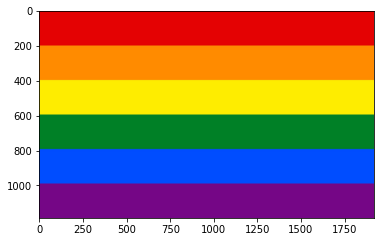

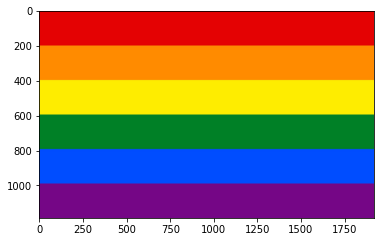

In [9]:
#@title 3.1 Parámetros de ejecución de GPU: { vertical-output: true }
#@markdown ### Mueve las barras deslizables para establecer cuanto influencia ese color en la imagen:

try:

  rojo = 1 #@param {type:"slider", min:0, max:1, step:0.001}
  verde = 1 #@param {type:"slider", min:0, max:1, step:0.001}
  azul = 1 #@param {type:"slider", min:0, max:1, step:0.001}

  %matplotlib inline
  from datetime import datetime
  tiempo_total = datetime.now()

  import matplotlib.pyplot as plt
  import numpy
  from PIL import Image 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule

  # --------------------------------------------
  # Definición de función que transforma el tiempo en  milisegundos 
  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
  # --------------------------------------------

  img_nombre = 'imagen.jpg'
  image = Image.open( img_nombre ) 
    
  # summarize some details about the image 
  img_alto, img_ancho = image.size 

  # Convierto la imagen comprimida en JPEG/PNG a array
  img_O_cpu = numpy.asarray(image)
  img_R_cpu = numpy.empty_like( img_O_cpu)

  # Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
  img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
  img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

  # GPU - Copio la memoria al GPU.
  cuda.memcpy_htod( img_O_gpu, img_O_cpu )
  cuda.memcpy_htod( img_R_gpu, img_R_cpu )

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_img(int ancho, int alto, char *img_O, char *img_R, float rojo, float verde, float azul )
  {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;
    float fRojo= 0.0;
    float fVerde = 0.0;
    float fAzul = 0.0;

    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy < alto )
    {      
          fRojo = (float)img_O[(idx+(idy*ancho))*3    ]*rojo;  // Componente Rojo del canal.
          fRojo +=(float)img_O[((idx+(idy*ancho)))*3+1]*0;  // Componente Verde del canal.
          fRojo +=(float)img_O[((idx+(idy*ancho)))*3+2]*0;   // Componente Azul del canal.

          fVerde = (float)img_O[(idx+(idy*ancho))*3    ]*0;  // Componente Rojo del canal.
          fVerde +=(float)img_O[((idx+(idy*ancho)))*3+1]*verde;  // Componente Verde del canal.
          fVerde +=(float)img_O[((idx+(idy*ancho)))*3+2]*0;   // Componente Azul del canal.

          fAzul = (float)img_O[(idx+(idy*ancho))*3    ]*0;  // Componente Rojo del canal.
          fAzul +=(float)img_O[((idx+(idy*ancho)))*3+1]*0;  // Componente Verde del canal.
          fAzul +=(float)img_O[((idx+(idy*ancho)))*3+2]*azul;   // Componente Azul del canal.
          // Escribo el color del canal.
          img_R[(idx+(idy*ancho))*3  ] = (char) fRojo;
          img_R[(idx+(idy*ancho))*3+1] = (char) fVerde;
          img_R[(idx+(idy*ancho))*3+2] = (char) fAzul;
      
    }
  }
  """) 

  # Muestro los atributos de la imagen y como se ve antes del seudo filtro.
  print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_img")

  tiempo_img = datetime.now()

  dim_hilo_x = 16
  dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

  dim_hilo_y = 19
  dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

  print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
  print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

  tiempo_img = datetime.now()

  kernel(numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu,numpy.float32(rojo),numpy.float32(verde),numpy.float32(azul), block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

  tiempo_img = datetime.now() - tiempo_img

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

  # Muestro la imagen Original el filtro.
  plt.figure()
  imgplot=plt.imshow( img_O_cpu )

  # Muestro la imagen luego de aplicarle el filtro.
  plt.figure()
  imgplot=plt.imshow( img_R_cpu )

  tiempo_total = datetime.now() - tiempo_total

  print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
  print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

except ModuleNotFoundError as err:
  print("No se encuentra el modulo Pycuda. Por favor ejecuta el armado del ambiente.")
  print(err)
except FileNotFoundError as err:
  print("No se encuentra cargada la imágen. Por favor ejecuta el armado del ambiente.")
  print(err)
except Exception as err:
  print("Ocurrió un error inesperado")
  print(err)

---
# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  wget url_imagen       | Lectura de la direcciòn URL de la imagen (jpg) a procesar.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  @param                | Lectura de los parametros ingresados.
CPU      |  matplotlib inline    | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado. 
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para las imagenes en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores en crudo de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el còdigo del kernel.
CPU      |  module.get_function() | convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      |  print()               | Informa los atributos de la imagen.
CPU      | cuda.memcpy_dtoh()     | Copia desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra la imagen resultado.

---
# 5 Conclusiones

El procesamiento de una imágen es muy costoso ya que tiene que trabajar en dos dimensiones (alto y ancho). 
Una imágen de tamaño 800*600 (que es relativamente de baja resolucion ya que hay imágenes de 2560*1024) tiene que procesar 480.000 pixeles.

Al trabajar con procesamiento secuencial (**CPU**) se debe trabajar con bucles anidados para cubrir las dos dimensiones de la imágen por lo que la complejidad computaciónal es de tipo cuadrática por lo que los tiempos de respuestas son muy elevados. El tiempo de respuesta depende del tamaño de la imagén, un pequeño incremento en el tamaño de la imagén incrementa considerablemente el tiempo de respuesta.



Cuando se trabaja con procesamiento paralelo (**CPU-GPU**) cada hilo ejecutado accede y modifica directamente un pixel de la imágen y al trabajar estos hilos de forma concurrente se eliminan los bucles anidados reduciendo así la complejidad computacional obteniendo muy buenos tiempos de respuestas incluso para imagenes con alta resolución.

---
# 6 Bibliografía


[1] Procesamiento de imagenes: [PDF](http://www2.elo.utfsm.cl/~elo328/pdf1dpp/PDI13_Color_1dpp.pdf)

[2] Canales de imagen digital: [Wiki](https://es.wikipedia.org/wiki/Canal_(imagen_digital) 